### Workflow

https://github.com/geosensing/geo_sampling/blob/public/docs/workflow.rst

In [29]:
#%pip install allocator
#%pip install geo_sampling

import geo_sampling
import allocator
import shapefile
import pandas as pd
import random
import numpy as np

from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

In [12]:
# Load the shapefile (both .shp and .dbf should be in the same directory)
shp_path = "gadm41_IND_shp/gadm41_IND_2.shp"  # Update path if needed
sf = shapefile.Reader(shp_path)

# Extract the fields and records
fields = [field[0] for field in sf.fields[1:]]  # Ignore first field ('DeletionFlag')
records = sf.records()

# Find the index of the "NAME_1" field (which contains "NCT of Delhi")
name_index = fields.index("NAME_1")  

# Extract polylines for "NCT of Delhi"
delhi_shapes = [shape for record, shape in zip(records, sf.shapes()) if record[name_index] == "NCT of Delhi"]

# Get bounding box (min_x, min_y, max_x, max_y)
all_points = [point for shape in delhi_shapes for point in shape.points]
min_x = min(p[0] for p in all_points)
min_y = min(p[1] for p in all_points)
max_x = max(p[0] for p in all_points)
max_y = max(p[1] for p in all_points)

In [13]:
# Construct BBBike extract URL
bbbike_url = f"http://extract.bbbike.org/?sw_lng={min_x}&sw_lat={min_y}&ne_lng={max_x}&ne_lat={max_y}"
print("BBBike Extract URL:", bbbike_url)

BBBike Extract URL: http://extract.bbbike.org/?sw_lng=76.83291625900006&sw_lat=28.408460617000003&ne_lng=77.33773803700012&ne_lat=28.884511947000078


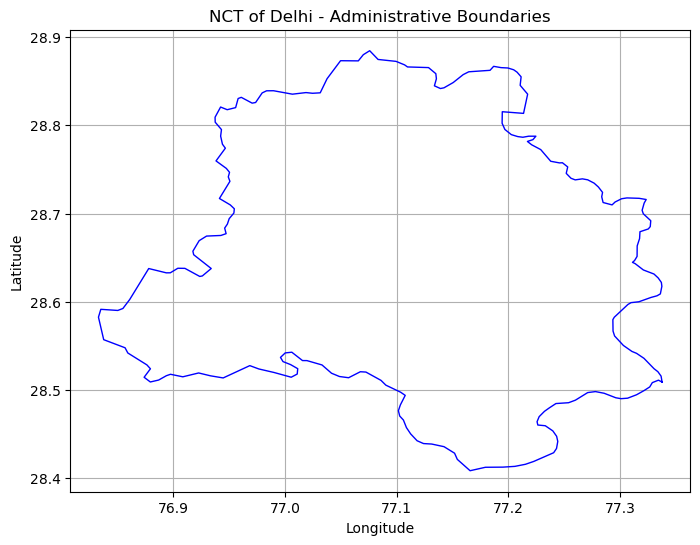

In [14]:
# Plot Delhi map
plt.figure(figsize=(8, 6))
for shape in delhi_shapes:
    x, y = zip(*shape.points)  # Extract x and y coordinates
    plt.plot(x, y, 'b', linewidth=1)

plt.title("NCT of Delhi - Administrative Boundaries")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [15]:
# Load the roads shapefile
roads_shp_path = "/Users/soodoku/Documents/GitHub/missing_women/planet_76.833,28.408_77.338,28.885-shp/shape/roads.shp"  # Update path if needed
sf = shapefile.Reader(roads_shp_path)

# Extract fields and records
fields = [field[0] for field in sf.fields[1:]]  # Skip first field ('DeletionFlag')
records = sf.records()

# Inspect field names to find relevant ones
print("Fields in shapefile:", fields)

Fields in shapefile: ['osm_id', 'name', 'ref', 'type', 'oneway', 'bridge', 'maxspeed']


In [19]:
# Assume "road_type" or similar field exists; update this based on inspection
road_type_field = "type"  # Update if needed
road_type_index = fields.index(road_type_field)

unique_road_types = set(record[road_type_index] for record in sf.records())
print("Unique road types in shapefile:", unique_road_types)

Unique road types in shapefile: {'secondary_link', 'footway', 'services', 'cycleway', 'bridleway', 'corridor', 'pedestrian', 'road', 'primary', 'construction', 'primary_link', 'trunk_link', 'residential', 'rest_area', 'secondary', 'trunk', 'living_street', 'motorway_link', 'track', 'tertiary_link', 'unclassified', 'bus_stop', 'service', 'raceway', 'busway', 'steps', 'tertiary', 'proposed', 'path', 'motorway'}


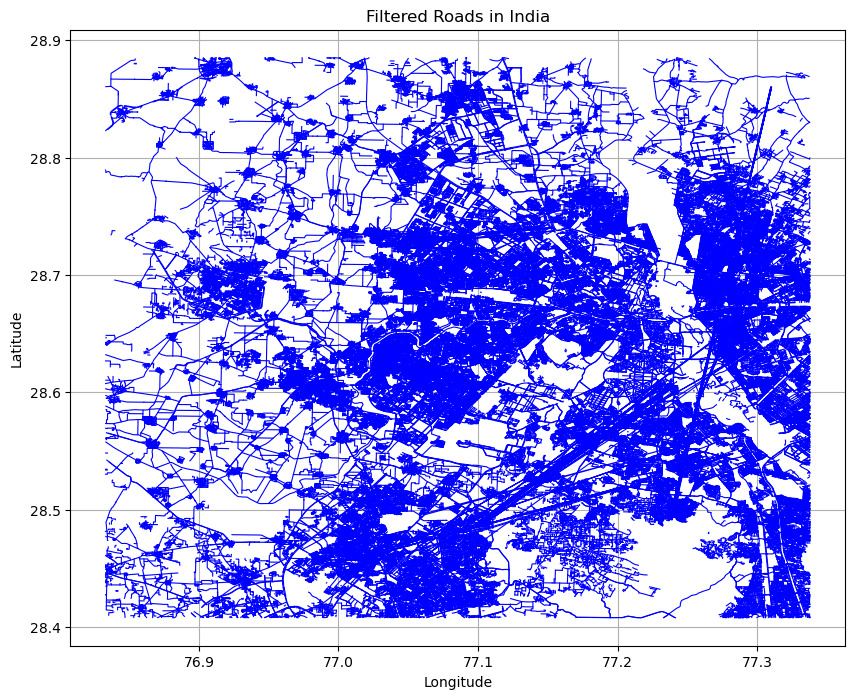

In [20]:
# Define road types to filter (e.g., "highway", "main road", "primary road")
road_types_of_interest = ["residential", "primary", "secondary", "tertiary"]

# Extract roads of interest
selected_roads = [shape for record, shape in zip(records, sf.shapes()) if record[road_type_index] in road_types_of_interest]

# Plot the selected roads
plt.figure(figsize=(10, 8))

for shape in selected_roads:
    x, y = zip(*shape.points)  # Extract coordinates
    plt.plot(x, y, 'b', linewidth=0.8)  # Plot with blue color

plt.title("Filtered Roads in Delhi")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [26]:
# Extract field names
fields = [field[0] for field in sf.fields[1:]]  # Ignore DeletionFlag
print("Fields:", fields)  # Identify road type field

# Extract road data into a DataFrame
road_data = []
for record, shape in zip(sf.records(), sf.shapes()):
    if shape.shapeType == 3:  # Ensure it's a polyline
        start_lat, start_long = shape.points[0]
        end_lat, end_long = shape.points[-1]
        road_data.append(list(record) + [start_lat, start_long, end_lat, end_long])

# Create DataFrame
df_roads = pd.DataFrame(road_data, columns=fields + ["start_lat", "start_long", "end_lat", "end_long"])

# Display sample
df_roads.head()

Fields: ['osm_id', 'name', 'ref', 'type', 'oneway', 'bridge', 'maxspeed']


,osm_id,name,ref,type,oneway,bridge,maxspeed,start_lat,start_long,end_lat,end_long
0,5873630,Mahatma Gandhi Marg,,trunk,1,0,NaN,77.231616,28.670095,77.229351,28.679178
1,7892104,,,service,0,0,NaN,77.167978,28.542586,77.167668,28.543099
2,7892285,JNU Ring Road,,service,0,0,NaN,77.164386,28.538417,77.170165,28.542581
3,7892369,,,service,0,0,NaN,77.166425,28.542953,77.167759,28.543285
4,7892539,,,service,0,0,NaN,77.162098,28.546591,77.165829,28.543064


In [28]:
df_roads.columns

Index(['osm_id', 'name', 'ref', 'type', 'oneway', 'bridge', 'maxspeed',
       'start_lat', 'start_long', 'end_lat', 'end_long'],
      dtype='object')

In [30]:
# Let's chunk with Haversine

def haversine(lat1, lon1, lat2, lon2):
    """Compute the Haversine distance (in meters) between two lat/lon points."""
    R = 6371000  # Earth's radius in meters
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in meters

In [31]:
# Compute road segment length in meters
df_roads["LENGTH_M"] = df_roads.apply(
    lambda row: haversine(row["start_lat"], row["start_long"], row["end_lat"], row["end_long"]),
    axis=1
)

# Check length distribution
print(df_roads["LENGTH_M"].describe())

count    217142.000000
mean        115.509602
std         294.763253
min           0.000000
25%          24.342177
50%          58.334072
75%         124.434209
max       26570.002324
Name: LENGTH_M, dtype: float64


In [35]:
def split_road_segment(row, segment_length=500):
    """Splits a road segment into equal chunks of segment_length (in meters)."""
    road_length = row["LENGTH_M"]
    
    if road_length <= segment_length:
        return [row.to_dict()]  # Return original row as a list to avoid NaNs

    num_segments = int(np.ceil(road_length / segment_length))  # Number of 500m chunks

    start_lat, start_long = row["start_lat"], row["start_long"]
    end_lat, end_long = row["end_lat"], row["end_long"]

    lat_step = (end_lat - start_lat) / num_segments
    long_step = (end_long - start_long) / num_segments

    split_segments = []
    for i in range(num_segments):
        new_start_lat = start_lat + (i * lat_step)
        new_start_long = start_long + (i * long_step)
        new_end_lat = new_start_lat + lat_step
        new_end_long = new_start_long + long_step

        new_segment = row.to_dict()
        new_segment["start_lat"] = new_start_lat
        new_segment["start_long"] = new_start_long
        new_segment["end_lat"] = new_end_lat
        new_segment["end_long"] = new_end_long
        new_segment["SEGMENT_PART"] = i + 1
        new_segment["LENGTH_M"] = segment_length  # Set length to 500m

        split_segments.append(new_segment)

    return split_segments

In [38]:
df_long_roads = df_roads[df_roads["LENGTH_M"] > 500]
df_short_roads = df_roads[df_roads["LENGTH_M"] <= 500]

# Apply fixed chunking function
df_long_roads_split = df_long_roads.apply(split_road_segment, axis=1)

# Ensure list format before explode()
df_long_roads_split = df_long_roads_split.explode().reset_index(drop=True)

# Convert dictionaries back to DataFrame
df_long_roads_split = pd.DataFrame(list(df_long_roads_split))

# Combine back
df_roads_final = pd.concat([df_short_roads, df_long_roads_split], ignore_index=True)

print("✅ Roads successfully chunked into 500m segments!")

✅ Roads successfully chunked into 500m segments!


In [39]:
# Randomly sample 1000 roads
df_sampled = df_roads_final.sample(n=1000, random_state=42)  # Change `n` if needed

df_sampled.head()

,osm_id,name,ref,type,oneway,bridge,maxspeed,start_lat,start_long,end_lat,end_long,LENGTH_M,SEGMENT_PART
87730,614071986,,,trunk_link,1,0,NaN,77.256056,28.644213,77.254810,28.645793,143.852342,NaN
197264,1251936107,,,living_street,0,0,NaN,77.262969,28.664433,77.263347,28.663688,45.797766,NaN
210697,28605695,,,residential,0,0,NaN,77.105612,28.417425,77.102930,28.417412,500.000000,2.0
124495,1070998590,,,service,0,0,NaN,77.121585,28.529682,77.120578,28.529809,111.983622,NaN
211074,37222918,Doctor Avul Pakir Jainulabdeen Abdul Kalam Marg,,secondary,1,0,NaN,77.223604,28.603202,77.220850,28.601928,500.000000,1.0


In [40]:
# Let's sort segments by distance

# Extract lat/lon from the sampled dataset
coords = df_sampled[['start_lat', 'start_long']].to_numpy()

# Compute pairwise Haversine distances
def haversine_distance_matrix(coords):
    """Compute distance matrix using the Haversine formula."""
    def haversine(p1, p2):
        R = 6371000  # Earth's radius in meters
        lat1, lon1, lat2, lon2 = np.radians([p1[0], p1[1], p2[0], p2[1]])
        dlat, dlon = lat2 - lat1, lon2 - lon1
        a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
        return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return squareform(pdist(coords, metric=haversine))

# Compute distance matrix
distance_matrix = haversine_distance_matrix(coords)

In [43]:
from scipy.spatial import distance

def nearest_neighbor_sort(distance_matrix):
    """Sort indices by nearest neighbor heuristic."""
    n = len(distance_matrix)
    visited = np.zeros(n, dtype=bool)
    sorted_indices = [0]  # Start from the first segment
    visited[0] = True

    for _ in range(1, n):
        last_index = sorted_indices[-1]
        remaining_indices = np.where(~visited)[0]  # Unvisited points
        nearest_index = remaining_indices[np.argmin(distance_matrix[last_index, remaining_indices])]
        sorted_indices.append(nearest_index)
        visited[nearest_index] = True

    return sorted_indices

# Get sorting order
sorted_order = nearest_neighbor_sort(distance_matrix)

# Reorder DataFrame
df_sorted = df_sampled.iloc[sorted_order].reset_index(drop=True)

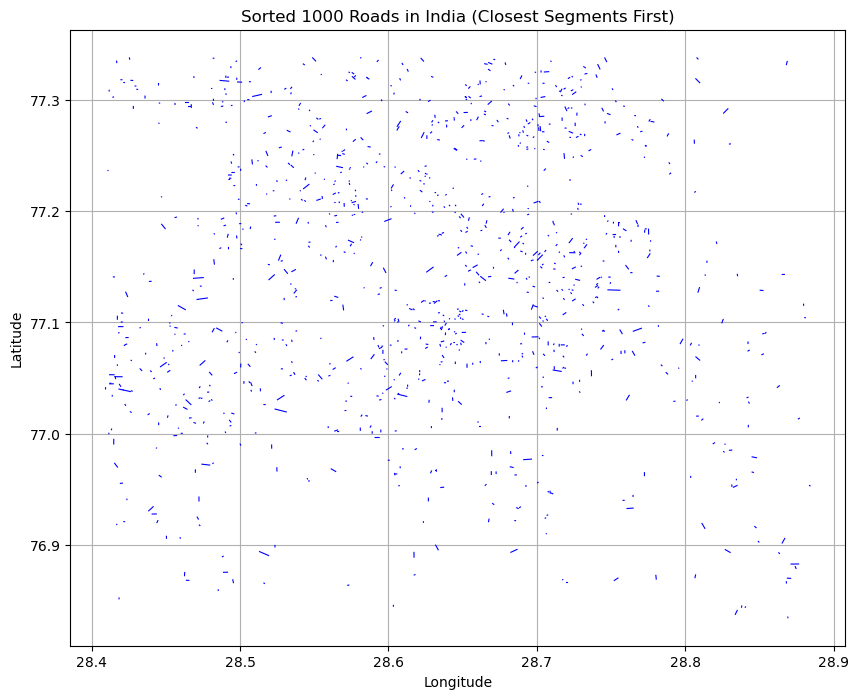

In [44]:
plt.figure(figsize=(10, 8))

for _, row in df_sorted.iterrows():
    x = [row["start_long"], row["end_long"]]
    y = [row["start_lat"], row["end_lat"]]
    plt.plot(x, y, 'b', linewidth=0.8)

plt.title("Sorted 1000 Roads in India (Closest Segments First)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [45]:
def haversine(lat1, lon1, lat2, lon2):
    """Compute the Haversine distance (in meters) between two lat/lon points."""
    R = 6371000  # Earth's radius in meters
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in meters

# Compute travel distances between consecutive segments
df_sorted["travel_distance"] = df_sorted.apply(
    lambda row: haversine(row["end_lat"], row["end_long"], row["start_lat"], row["start_long"]), axis=1
)

In [47]:
MAX_ITINERARY_DISTANCE = 20000  # 20 km in meters

itineraries = []
current_itinerary = []
current_distance = 0
itinerary_id = 1

for i, row in df_sorted.iterrows():
    segment_length = row["LENGTH_M"]
    travel_distance = row["travel_distance"] if i > 0 else 0  # No travel for the first segment

    if current_distance + segment_length + travel_distance > MAX_ITINERARY_DISTANCE:
        itineraries.append({"itinerary_id": itinerary_id, "segments": current_itinerary})
        current_itinerary = []
        current_distance = 0
        itinerary_id += 1

    current_itinerary.append(row.to_dict())
    current_distance += segment_length + travel_distance

# Add the last itinerary
if current_itinerary:
    itineraries.append({"itinerary_id": itinerary_id, "segments": current_itinerary})

print(f"✅ Created {len(itineraries)} itineraries.")

✅ Created 12 itineraries.


In [48]:
# Flatten the itineraries
flat_data = []
for itinerary in itineraries:
    itinerary_id = itinerary["itinerary_id"]
    for segment in itinerary["segments"]:
        segment["itinerary_id"] = itinerary_id
        flat_data.append(segment)

# Convert to DataFrame
df_itineraries = pd.DataFrame(flat_data)

# Save to CSV
df_itineraries.to_csv("itineraries.csv", index=False)
print("✅ Saved itineraries to 'itineraries.csv'.")

✅ Saved itineraries to 'itineraries.csv'.


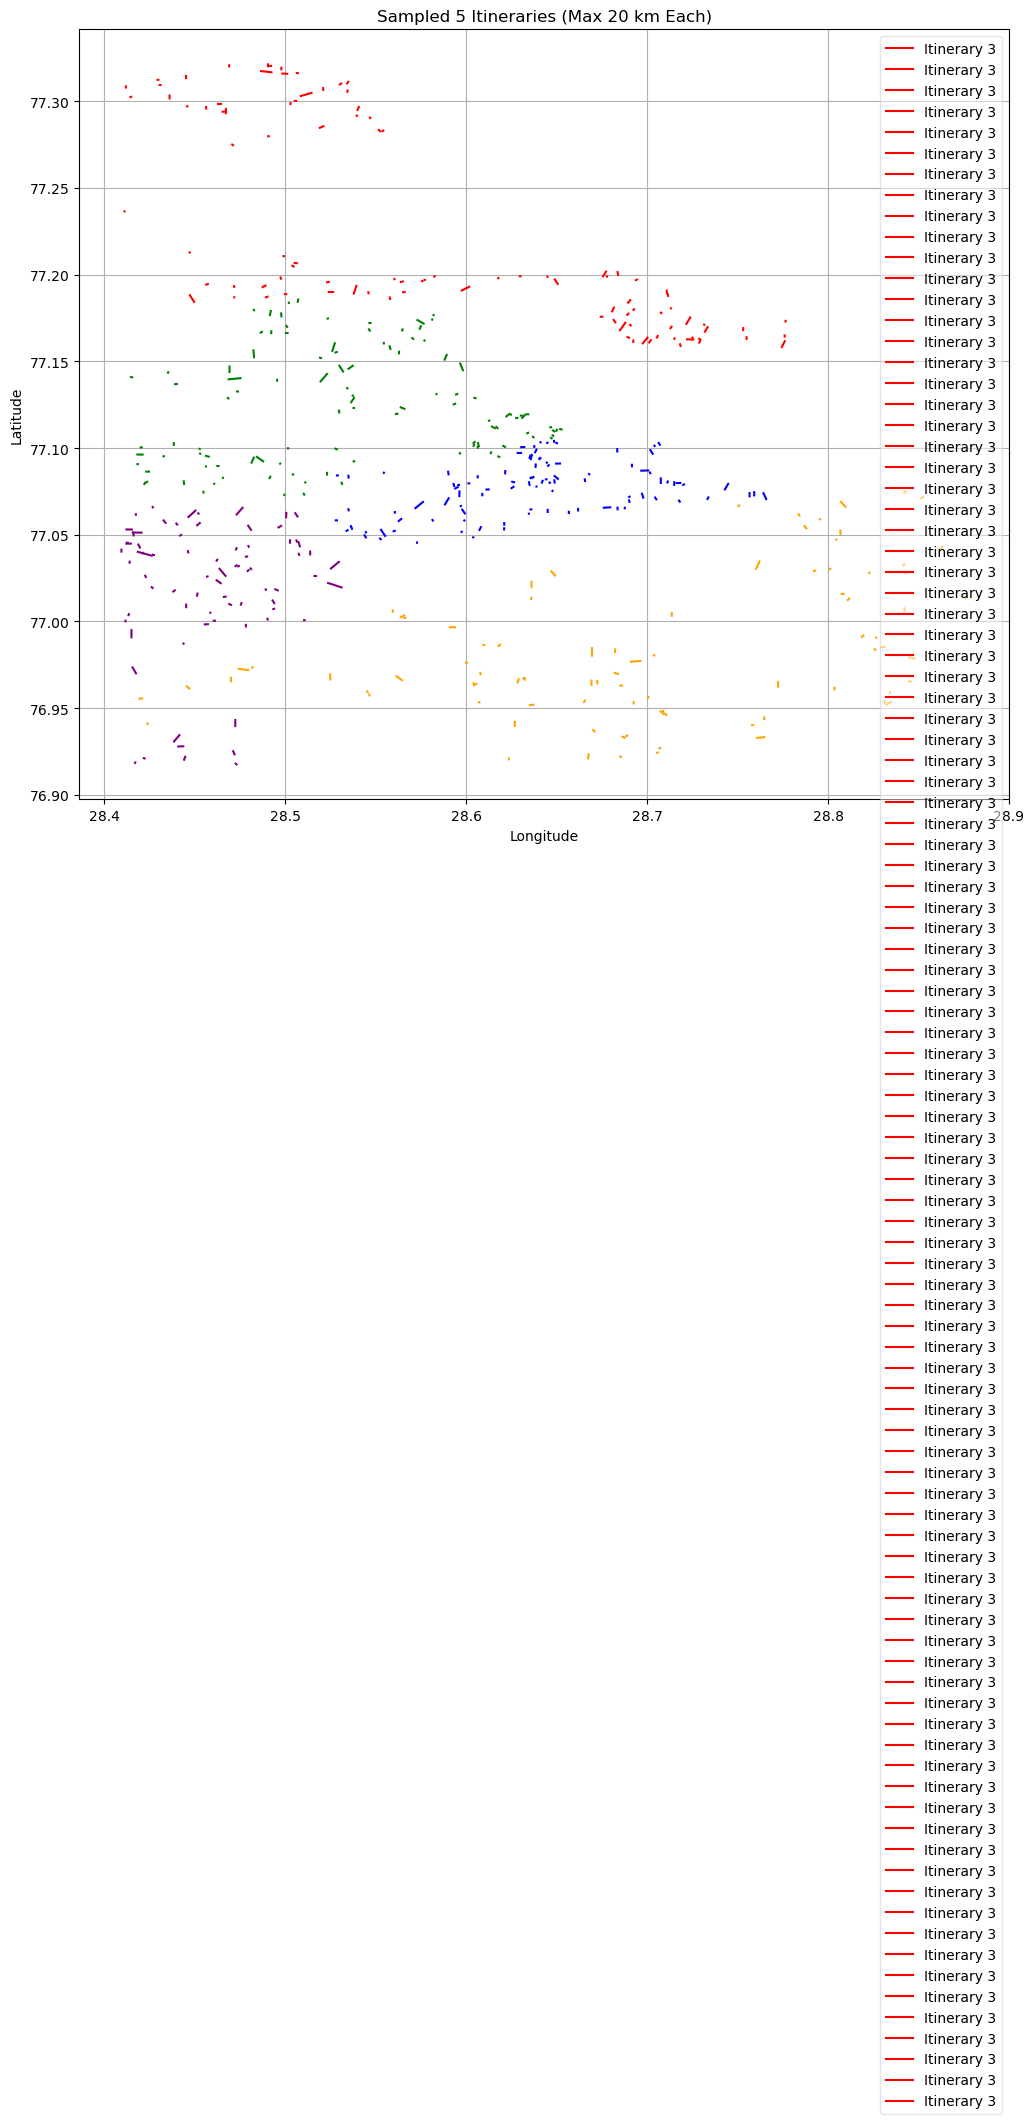

In [49]:
# Select 5 random itineraries
sample_itineraries = random.sample(df_itineraries["itinerary_id"].unique().tolist(), 5)
colors = ["red", "blue", "green", "purple", "orange"]

plt.figure(figsize=(12, 10))

for i, itinerary_id in enumerate(sample_itineraries):
    df_subset = df_itineraries[df_itineraries["itinerary_id"] == itinerary_id]

    for _, row in df_subset.iterrows():
        x = [row["start_long"], row["end_long"]]
        y = [row["start_lat"], row["end_lat"]]
        plt.plot(x, y, color=colors[i], linewidth=1.5, label=f"Itinerary {itinerary_id}" if i == 0 else "")

plt.title("Sampled 5 Itineraries (Max 20 km Each)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc="best", fancybox=True, framealpha=0.5)
plt.grid(True)
plt.show()

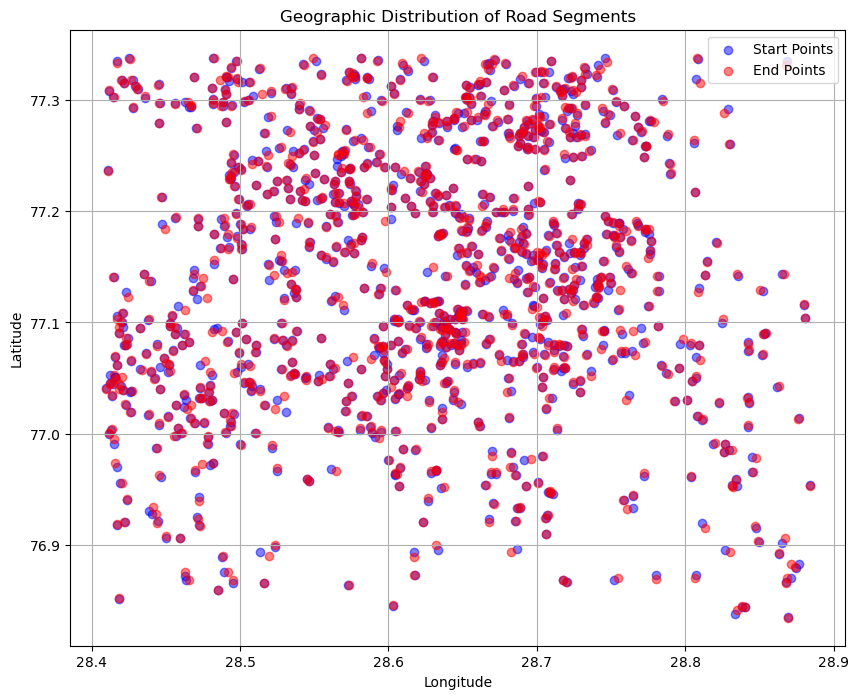

In [53]:
plt.figure(figsize=(10, 8))
plt.scatter(df_sorted["start_long"], df_sorted["start_lat"], color='blue', label="Start Points", alpha=0.5)
plt.scatter(df_sorted["end_long"], df_sorted["end_lat"], color='red', label="End Points", alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of Road Segments")
plt.legend()
plt.grid()
plt.show()

In [54]:
# Swap lat/lon if values are incorrect
df_sorted["start_lat"], df_sorted["start_long"] = df_sorted["start_long"], df_sorted["start_lat"]
df_sorted["end_lat"], df_sorted["end_long"] = df_sorted["end_long"], df_sorted["end_lat"]


In [55]:
### Google Maps
import urllib.parse

def generate_google_maps_url(segments):
    """Creates a Google Maps directions URL from a list of road segments."""
    base_url = "https://www.google.com/maps/dir/"
    waypoints = []

    for segment in segments:
        lat, lon = segment["start_lat"], segment["start_long"]
        waypoints.append(f"{lat},{lon}")

    # Append last segment's end point
    last_segment = segments[-1]
    waypoints.append(f"{last_segment['end_lat']},{last_segment['end_long']}")

    # Encode waypoints into URL
    url = base_url + "/".join(waypoints)
    return urllib.parse.quote(url, safe=':/,')  # Ensure URL encoding

# Generate Google Maps URLs for each itinerary
itinerary_links = []
for itinerary in itineraries:
    itinerary_id = itinerary["itinerary_id"]
    url = generate_google_maps_url(itinerary["segments"])
    itinerary_links.append({"itinerary_id": itinerary_id, "google_maps_url": url})

# Convert to DataFrame
df_maps = pd.DataFrame(itinerary_links)

# Save the links
df_maps.to_csv("google_maps_itineraries.csv", index=False)
print("✅ Saved Google Maps itinerary links to 'google_maps_itineraries.csv'.")

✅ Saved Google Maps itinerary links to 'google_maps_itineraries.csv'.


In [56]:
import urllib.parse

def generate_google_maps_urls(segments, max_waypoints=10):
    """
    Creates one or more Google Maps directions URLs from a list of road segments.
    Google Maps allows up to `max_waypoints` (default 10) in a single request.
    """
    base_url = "https://www.google.com/maps/dir/"
    urls = []

    # Process segments in chunks of `max_waypoints`
    for i in range(0, len(segments), max_waypoints - 1):  # -1 because the last point is end
        waypoint_chunk = segments[i:i + max_waypoints - 1]
        
        waypoints = [f"{seg['start_lat']},{seg['start_long']}" for seg in waypoint_chunk]

        # Append last segment's end point
        last_segment = waypoint_chunk[-1]
        waypoints.append(f"{last_segment['end_lat']},{last_segment['end_long']}")

        # Encode waypoints into URL
        url = base_url + "/".join(waypoints)
        urls.append(urllib.parse.quote(url, safe=':/,'))  # Ensure URL encoding

    return urls  # Returns a list of URLs if multiple needed


In [57]:
itinerary_links = []
for itinerary in itineraries:
    itinerary_id = itinerary["itinerary_id"]
    urls = generate_google_maps_urls(itinerary["segments"])

    for idx, url in enumerate(urls):
        itinerary_links.append({"itinerary_id": itinerary_id, "part": idx + 1, "google_maps_url": url})

# Convert to DataFrame
df_maps = pd.DataFrame(itinerary_links)

# Save the links
df_maps.to_csv("google_maps_itineraries.csv", index=False)
print("✅ Saved Google Maps itinerary links to 'google_maps_itineraries.csv'.")


✅ Saved Google Maps itinerary links to 'google_maps_itineraries.csv'.
